In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from MuCoST.mucost import training_model
from MuCoST.utils import mclust
from MuCoST.config import set_arg
from scipy.sparse import csr_matrix

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Importing MuCoST

In [2]:
opt = set_arg()
arg = opt.parse_args(['--mode_his', 'noh'])
arg.n_domain=7
arg.temp=0.3
arg.radius=50
arg

Namespace(seed=2023, latent_dim=50, epoch=1000, lr=0.001, weight_decay=0.0, log_step=10, drop_feat_p=0.2, flow='source_to_target', radius=50, rknn=6, knn=6, n_domain=7, temp=0.3, n_refine=25, mode_his='noh', mode_rknn='rknn')

### Reading Data

In [3]:
input_dir = os.path.join('Data/stereo-seq')
counts_file = os.path.join(input_dir, 'RNA_counts.tsv')
coor_file = os.path.join(input_dir, 'position.tsv')

In [4]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')

In [5]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [6]:
coor_df.head()

x            y
label                            
Spot_1  12555.007833  6307.537859
Spot_2  12623.666667  6297.166667
Spot_3  12589.567164  6302.552239
Spot_4  12642.495050  6307.386139
Spot_5  13003.333333  6307.990991

In [7]:
adata = sc.AnnData(counts.T)
adata.X = csr_matrix(adata.X)
adata.var_names_make_unique()

In [8]:
print(coor_df)

                       x             y
label                                 
Spot_1      12555.007833   6307.537859
Spot_2      12623.666667   6297.166667
Spot_3      12589.567164   6302.552239
Spot_4      12642.495050   6307.386139
Spot_5      13003.333333   6307.990991
...                  ...           ...
Spot_19888  14656.130435  12156.869565
Spot_19889  10717.785714  12189.571429
Spot_19890  10872.913580  12190.123457
Spot_19891  11628.769231  12191.846154
Spot_19892  13984.760000  12191.240000

[19527 rows x 2 columns]


In [9]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 19527 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(6002.432692307692, 12486.580128205129, 9908.545833333334, 15086.093055555555)

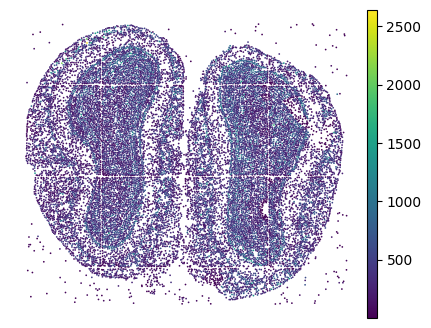

In [11]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [12]:
used_barcode = pd.read_csv(os.path.join('Data/stereo-seq/used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]

In [13]:
adata = adata[used_barcode,]

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

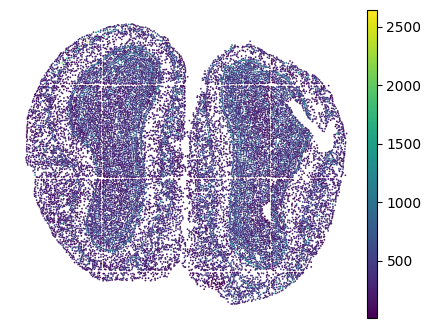

In [14]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [15]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

After flitering:  (19109, 14376)


/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


### Training model

In [16]:
adata.X

<19109x14376 sparse matrix of type '<class 'numpy.float64'>'
	with 6728390 stored elements in Compressed Sparse Row format>

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Average spatial edge: 6.237898372494636
Average feature edge: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

EP[ 100]: loss=2.1483.
EP[ 200]: loss=2.1291.
EP[ 300]: loss=2.1235.
EP[ 400]: loss=2.1209.
EP[ 500]: loss=2.1186.
EP[ 600]: loss=2.1173.
EP[ 700]: loss=2.1161.
EP[ 800]: loss=2.1144.
EP[ 900]: loss=2.1140.
EP[1000]: loss=2.1145.


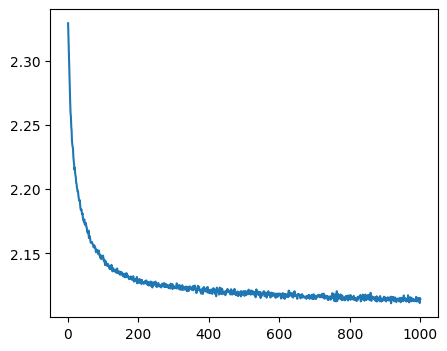

In [17]:
training_model(adata, arg)

### Clustering with ‘mclust’

In [18]:
adata = mclust(adata, arg, refine=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


### Visualization

In [19]:
sc.pp.neighbors(adata, use_rep='MuCoST')
sc.tl.umap(adata)

In [20]:
# sc.tl.louvain(adata, resolution=1.1)
# sc.pl.embedding(adata, basis="spatial", color="louvain",s=10, show=False, title='MuCoST')

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

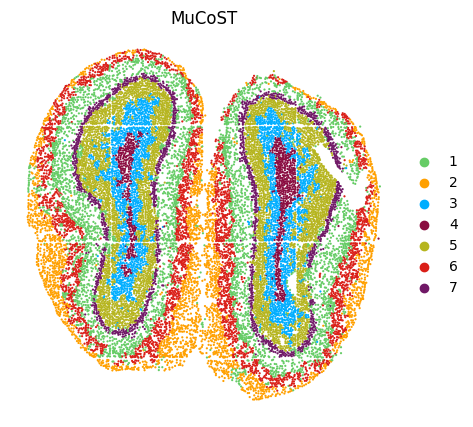

In [21]:
plot_color=["#66cc66","#ffa000","#00aeff","#8a0c40","#b6b51f","#da1f18",
            "#701866","#f47a75","#8736c7","#024b51"]
# plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
#              "#CD69C9","#EE7621","#B22222","#ACD700"]
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="mclust",s=10, palette=plot_color, show=False, title='MuCoST')
plt.axis('off')

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


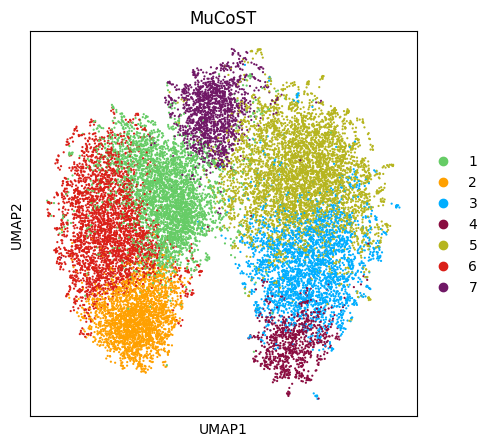

In [22]:
sc.pl.umap(adata, color='mclust',s=10, title='MuCoST')

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

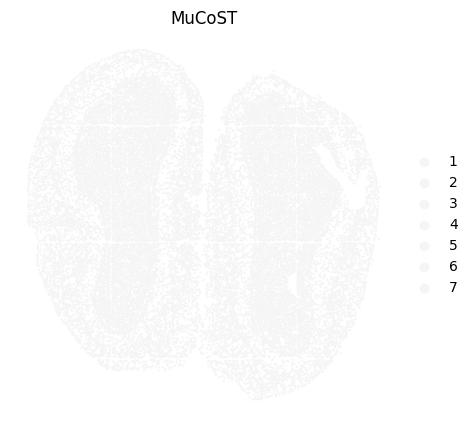

In [23]:
# plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
#             "#CD69C9","#EE7621","#B22222","#ACD700"]
# #F5F5F5
plot_color=["#66cc66","#ffa000","#00aeff","#8a0c40","#b6b51f",
            "#da1f18","#701866","#f47a75","#8736c7","#024b51"]
plot_color=['#F5F5F5', '#F5F5F5', '#F5F5F5', '#F5F5F5', '#F5F5F5',
             '#F5F5F5', '#F5F5F5', '#f47a75', '#F5F5F5', '#F5F5F5']
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="mclust",s=10, palette=plot_color, show=False, title='MuCoST')
plt.axis('off')

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. P

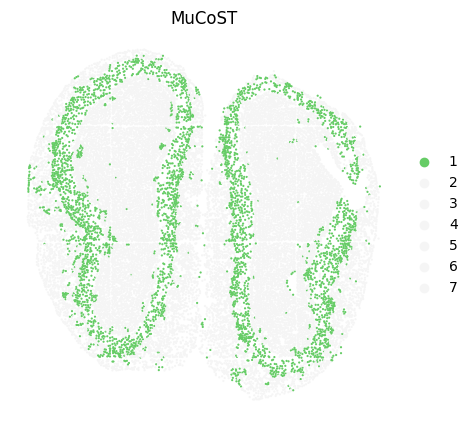

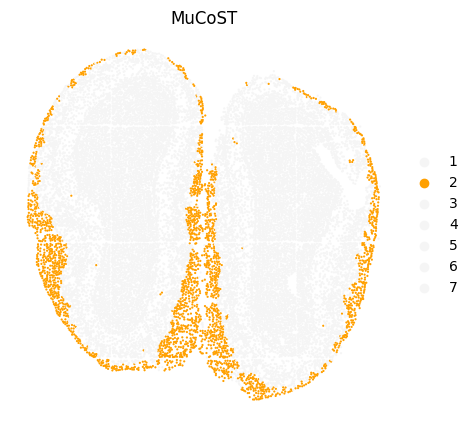

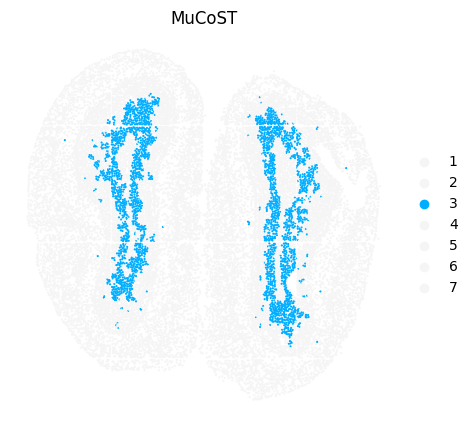

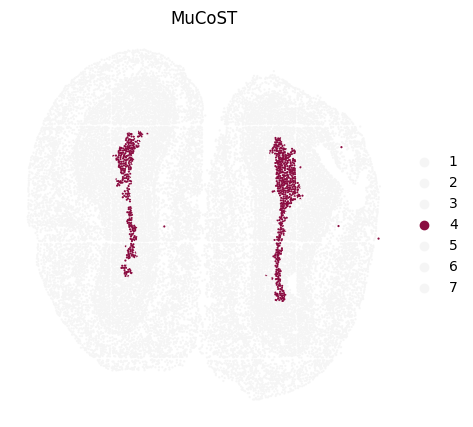

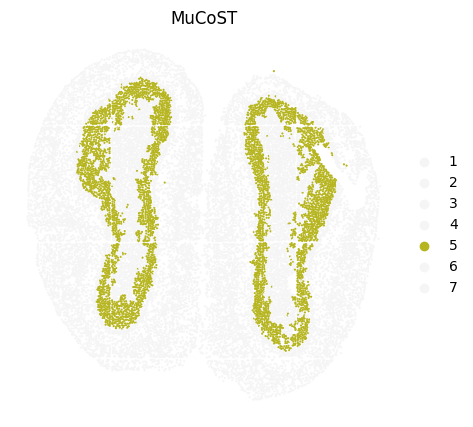

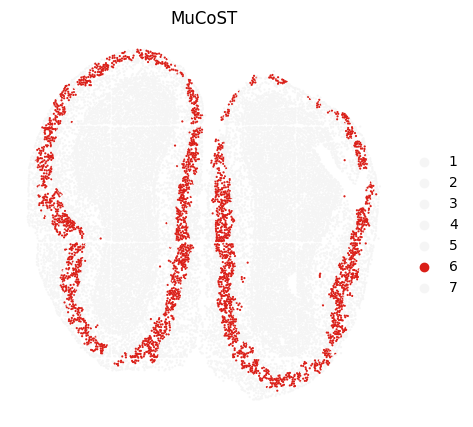

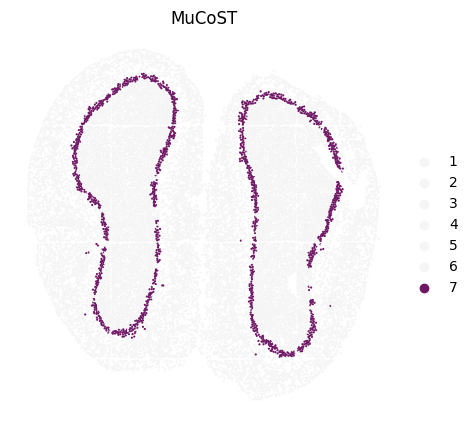

In [24]:
plot_colors=["#66cc66","#ffa000","#00aeff","#8a0c40","#b6b51f",
            "#da1f18","#701866"]
for i,indices in enumerate(plot_colors):
    plot_color=['#F5F5F5', '#F5F5F5', '#F5F5F5', '#F5F5F5', '#F5F5F5',
                '#F5F5F5', '#F5F5F5']
    plot_color[i]=indices
    plt.rcParams["figure.figsize"] = (5, 5)
    sc.pl.embedding(adata, basis="spatial", color="mclust",s=10, palette=plot_color, show=False, title='MuCoST')
    plt.axis('off')

In [25]:
# sc.pl.umap(adata, color='mclust',s=10, title='MuCoST')

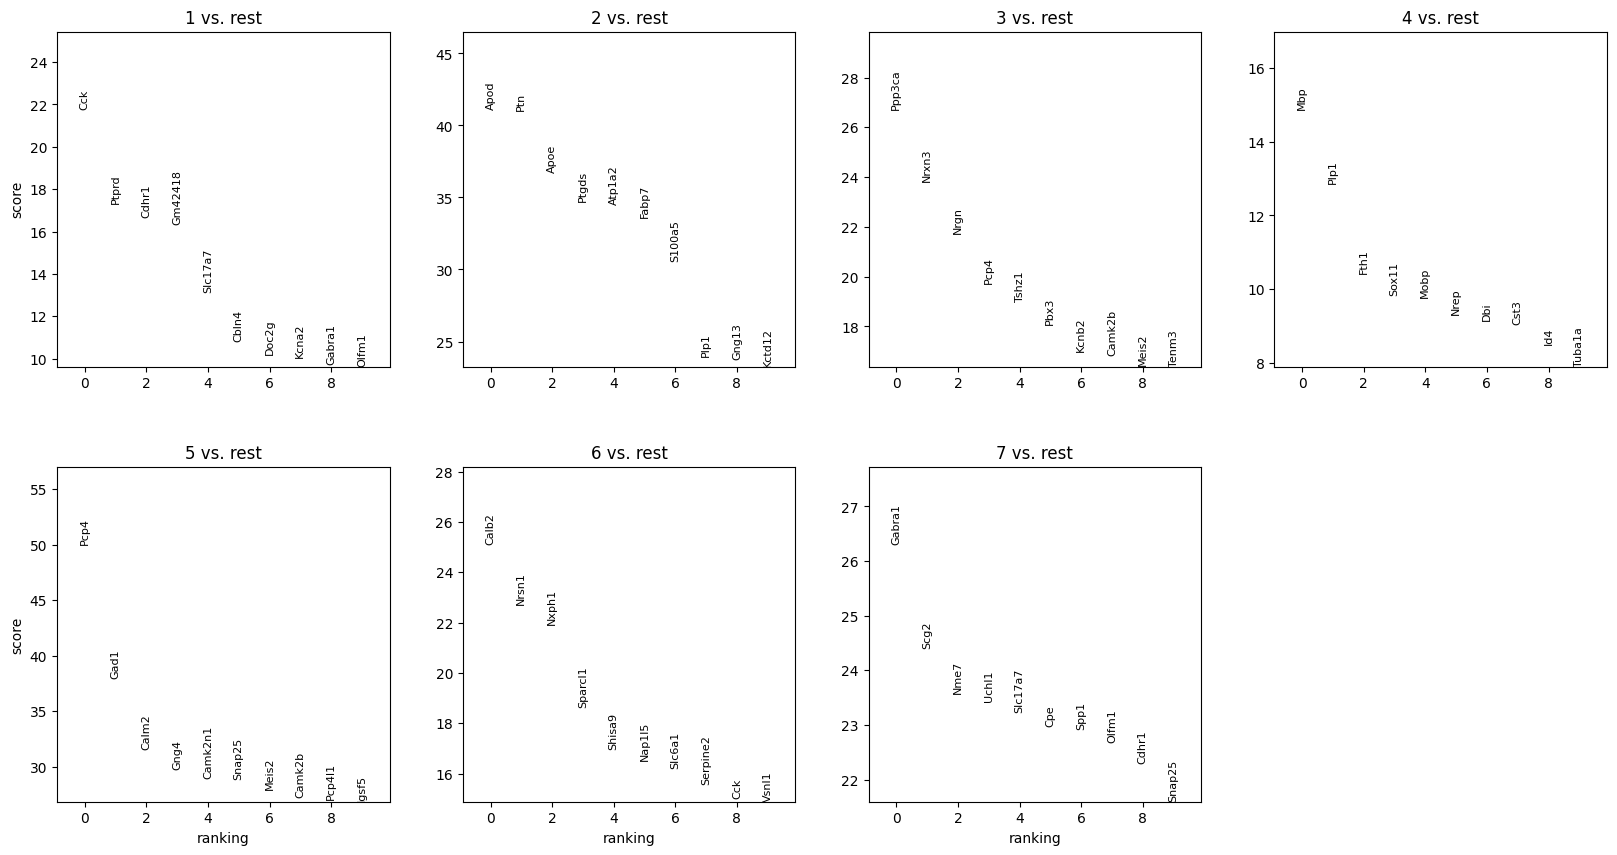

In [26]:
sc.tl.rank_genes_groups(adata, 'mclust', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

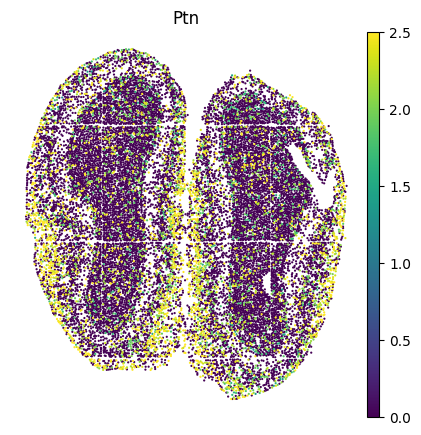

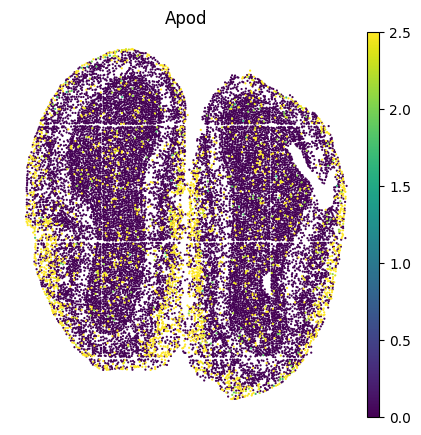

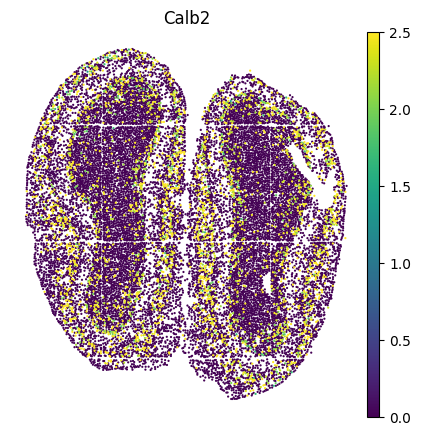

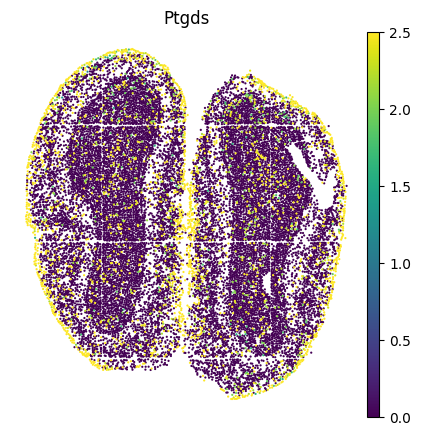

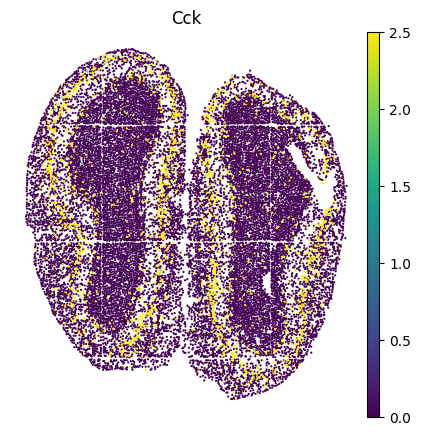

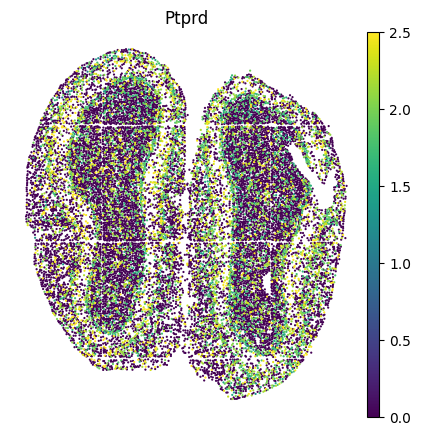

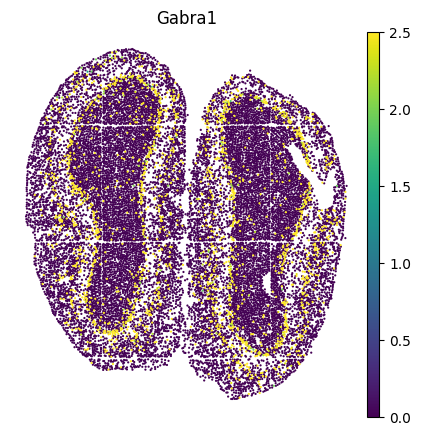

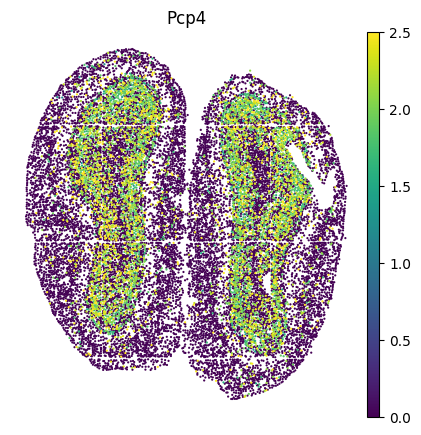

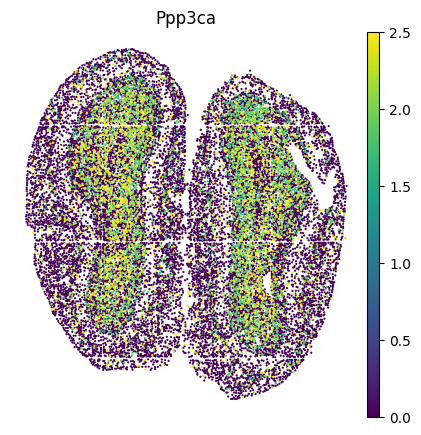

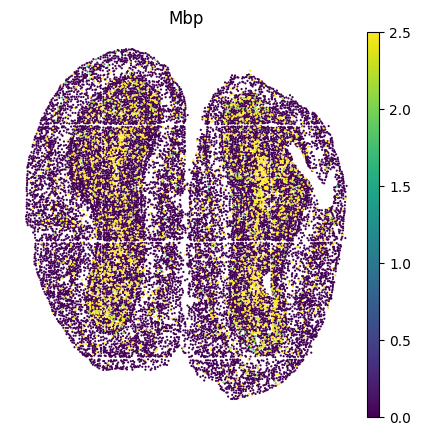

In [27]:
mark_genes = ['Ptn','Apod','Calb2', 'Ptgds','Cck','Ptprd', 'Gabra1','Pcp4','Ppp3ca','Mbp']
for i,indic in enumerate(mark_genes):
    sc.pl.embedding(adata, basis="spatial", color=indic,vmin=0, vmax=2.5, s=10, palette=plot_color, show=False)
    plt.axis('off')

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

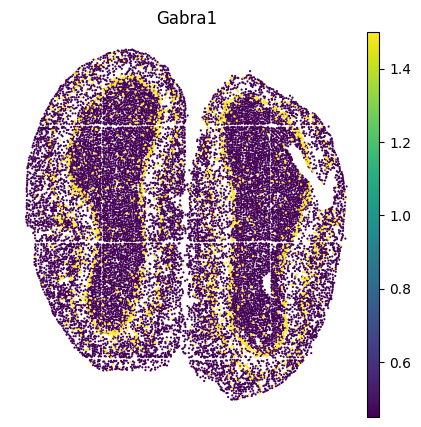

In [28]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color='Gabra1',vmin=1.5, vmax=0.5, s=10, palette=plot_color, show=False)
plt.axis('off')

/home/zhang/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


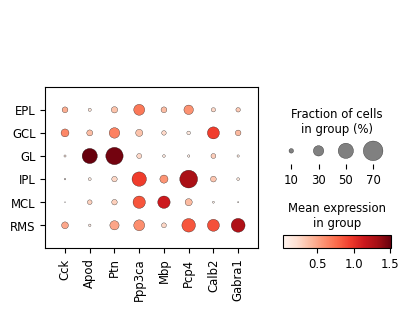

In [29]:
mark_genes = ['Cck','Apod','Ptn','Ppp3ca','Mbp','Pcp4','Calb2', 'Gabra1']
# cluster_anno={'9':'ONL-1','1':'ONL-2','3':'ONL-3','4':'GL','6':'EPL','2':'MCL','7':'IPL','10':'GCL-1','8':'GCL-2','5':'RMS'}
cluster_anno={'1':'EPL','2':'GL','3':'EPL','4':'MCL','5':'IPL','6':'GCL','7':'RMS'}
adata.obs['domain_type']=adata.obs['mclust'].astype('str').map(cluster_anno)
sc.pl.dotplot(adata, mark_genes, groupby='domain_type',dendrogram=False)

In [30]:
adata

AnnData object with n_obs × n_vars = 19109 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mclust', 'domain_type'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'mclust_colors', 'rank_genes_groups'
    obsm: 'spatial', 'raw_feature', 'MuCoST', 'emb_pca', 'X_umap'
    obsp: 'distances', 'connectivities'